In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sympy import *
from iminuit import Minuit
import scipy

In [2]:
drop_list = ['FRAC_DAYS_SINCE_JAN1', 'FRAC_HRS_SINCE_JAN1', 'EPOCH_TIME', 'ALARM_STATUS', 'INST_STATUS', 'CavityPressure', 
             'CavityTemp', 'WarmBoxTemp', 'EtalonTemp', 'DasTemp', 'MPVPosition', 'solenoid_valves', 'OutletValve', 
             'MeasurementMode', 'species', 'Delta_iCH4_Raw', 'HP_Delta_iCH4_Raw', 'HP_Delta_iCH4_30s', 'HP_Delta_iCH4_2min',
             'HP_Delta_iCH4_5min', 'HR_Delta_iCH4_Raw', 'HR_Delta_iCH4_30s', 'HR_Delta_iCH4_2min', 'HR_Delta_iCH4_5min',
             'ChemDetect', 'peak87_baseave_spec', 'peak88_baseave', 'ch4_splinemax', 'peak30_spec', 'peak_30', 
             'SSIMPressure', 'PPF_res', 'PPF_base_offset', 'PPF_slope_offset', 'PPF_shift', 'peakheight_5', 'peak0_spec',
             'Delta_Raw_iCO2', 'Delta_30s_iCO2', 'Delta_2min_iCO2', 'Delta_5min_iCO2']

In [3]:
data_11 = pd.read_table('./CFIDS2354-20230501-111006Z-DataLog_User.dat', sep = '\s+', index_col = 0)
data_12 = pd.read_table('./CFIDS2354-20230501-121014Z-DataLog_User.dat', sep = '\s+', index_col = 0)
data_13 = pd.read_table('./CFIDS2354-20230501-131021Z-DataLog_User.dat', sep = '\s+', index_col = 0)
data_14 = pd.read_table('./CFIDS2354-20230501-141030Z-DataLog_User.dat', sep = '\s+', index_col = 0)
data_15 = pd.read_table('./CFIDS2354-20230501-151038Z-DataLog_User.dat', sep = '\s+', index_col = 0)
data_16 = pd.read_table('./CFIDS2354-20230501-161047Z-DataLog_User.dat', sep = '\s+', index_col = 0)

frames = [data_11, data_12, data_13, data_14, data_15, data_16]

full_df = pd.concat(frames)
full_df = full_df.drop(drop_list, axis = 1)
full_df['TIME'] = full_df['TIME'].astype(str)

In [11]:
sec_list = []
for time in full_df['TIME']:
    date_time = datetime.datetime.strptime(time, '%H:%M:%S.%f')
    a_timedelta = date_time - datetime.datetime(1900, 1, 1)
    seconds = a_timedelta.total_seconds()
    sec_list.append(seconds)

sec_array = np.array(sec_list)
sec_array -= sec_array[0]

full_df['Sec'] = sec_array.tolist()

full_df = full_df[::4]

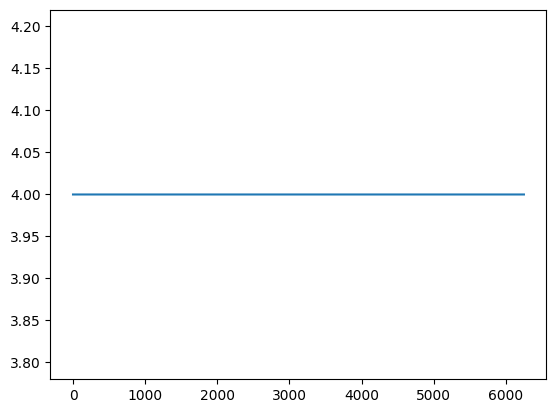

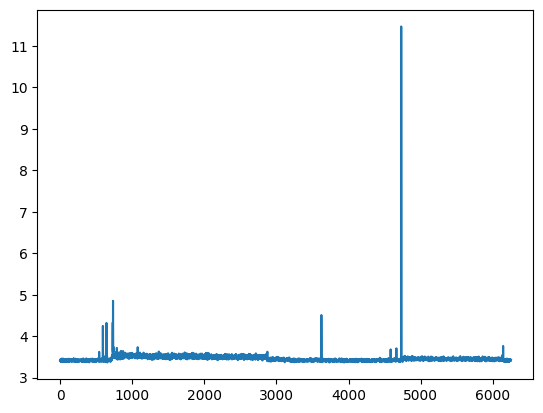

In [10]:
number_of_repeat = []
compare = 0
count = 0
for value in full_df["HR_12CH4"]:
    if value == compare:
        count += 1
    else:
        number_of_repeat.append(count)
        compare = value
        count = 1
plt.plot(number_of_repeat[1:])
plt.show()
plt.plot([i for i in range(int(full_df[::4]["Sec"].shape[0])-1)], full_df[::4][1:]["Sec"]- full_df[::4][:-1]["Sec"])
plt.show()

In [12]:
def geterrors_corr(z, symlist, vals, covmatrix):   
    # Written by Philip Kofoed-Djursner 
    def variances(func, symbols, values, covmatrix):
        # Makes a variance matrix which can we summed and sqrt'ed to find the uncertainty
        # **Need to be rework to it make more general for more correlations** 
        # **Would also be nice to not have a nested loop**
        variance = np.zeros((len(symbols), len(symbols)))
        for idx, isymbol in enumerate(symbols):
            for jdx, jsymbol in enumerate(symbols):
                
                f = lambdify(symbols, func.diff(isymbol) * func.diff(jsymbol) * covmatrix[idx, jdx])
                variance[idx, jdx] = f(*values)
        
        return variance
    Vz = variances(z, symlist, vals, covmatrix)
    print(Vz)
    sigmaz = np.sqrt(np.sum(Vz.flatten()))
    zvalue = lambdify(symlist, z)(*vals)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
    
    return zvalue, sigmaz

def exp_fit(xdata, xmin, xmax, ydata):
    f, V = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t), xdata[xmin:xmax], ydata[xmin:xmax], p0 = (85, -10**(-6)))
    a = f[0]
    b = f[1]
    fit = a*np.exp(b*xdata)
    mean_val = xdata[xmin:xmax].mean()
    # mean_y = a*np.exp(b*mean_val)
    return V, a, b, fit, mean_val

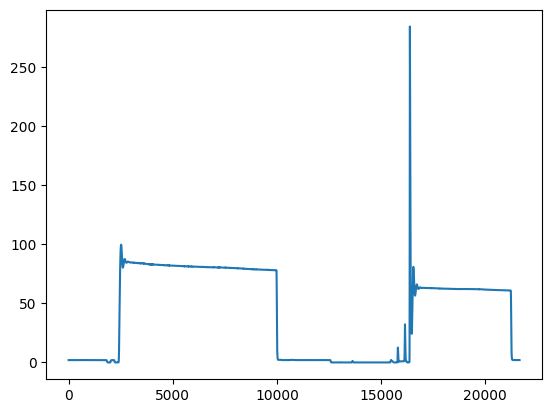

In [13]:
plt.plot(full_df['Sec'], full_df['HR_12CH4'])

In [17]:
for i, time in enumerate(full_df['TIME']):
    if '12:10:02' in time:
        print(i, time, 'exp1')
    if '12:55:01' in time:
        print(i, time, 'exp1')
    if '13:05:01' in time:
        print(i, time, 'exp1 light on')
    if '13:25:01' in time:
        print(i, time, 'exp1 light off')
    if '13:30:01' in time:
        print(i, time, 'exp1')
    if '13:35:02' in time:
        print(i, time, 'exp1')

1041 12:10:02.196 exp1
1810 12:55:01.280 exp1
1981 13:05:01.046 exp1 light on
2324 13:25:01.344 exp1 light off
2410 13:30:01.884 exp1
2496 13:35:02.637 exp1


In [18]:
V_before, a_before, b_before, full_df['fit_before_light'], meanx_before = exp_fit(full_df['Sec'], 1810, 1981, full_df['HR_12CH4'])
V_after, a_after, b_after, full_df['fit_after_light'], meanx_after = exp_fit(full_df['Sec'], 2410, 2496, full_df['HR_12CH4'])

print('Before light is turned on')
print('a: ', a_before, '+/-', np.sqrt(V_before[0][0]))
print('b: ', b_before, '+/-', np.sqrt(V_before[1][1]))
print('After light is turned off')
print('a: ', a_after, '+/-', V_after[0][0])
print('b: ', b_after, '+/-', V_after[1][1])

a_sym = Symbol('a')
b_sym = Symbol('b')
z_before = a_sym*exp(b_sym*meanx_after)
z_after = a_sym*exp(b_sym*meanx_after)

y_before, yerror_before = geterrors_corr(z_before, [a_sym, b_sym], [a_before, b_before], V_before)
y_after, yerror_after = geterrors_corr(z_after, [a_sym, b_sym], [a_after, b_after], V_after)

mean_exp1 = np.array([[full_df['Sec'][2410:2496].mean(), meanx_after, meanx_after], 
                      [full_df['HR_12CH4'][2410:2496].mean(), y_before, y_after]])
print(y_before, yerror_before)
print(y_after, yerror_after)

Before light is turned on
a:  85.09019260907384 +/- 0.09421782743574598
b:  -8.05274181145315e-06 +/- 1.6775195861458637e-07
After light is turned off
a:  89.63491461298035 +/- 0.09812007371022753
b:  -1.4513059633618349e-05 +/- 1.670593796775996e-13
[[ 0.00773508 -0.01001577]
 [-0.01001577  0.01297785]]
[[ 0.07655619 -0.07655026]
 [-0.07655026  0.07655221]]
79.42892535147564 0.026103422711391832
79.17506618417254 0.002809039018908033


In [19]:
print(full_df['Sec'][2410:2496].mean(), meanx_after)

8549.78143023256 8549.78143023256


In [89]:
79.4296829108239-79.17734767438452

0.2523352364393787

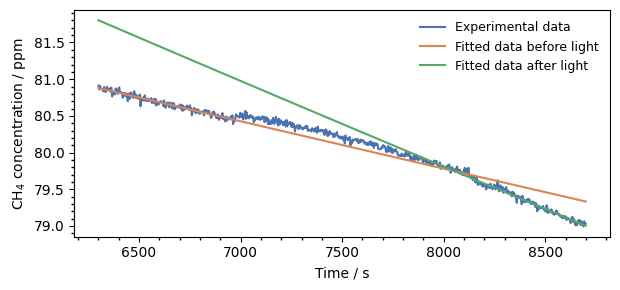

In [20]:
# Full experiment1
plt.figure(figsize = (6.3, 3))
sns.set_palette('deep')

ax = sns.lineplot(x = full_df['Sec'][1810:2496], y = full_df['HR_12CH4'][1810:2496], label = 'Experimental data')
sns.lineplot(x = full_df['Sec'][1810:2496], y = full_df['fit_before_light'][1810:2496], label = 'Fitted data before light')
sns.lineplot(x = full_df['Sec'][1810:2496], y = full_df['fit_after_light'][1810:2496], label = 'Fitted data after light')

ax.set_xlabel('Time / s')
ax.set_ylabel('CH$_{4}$ concentration / ppm')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis = 'both', which = 'major', direction = 'out', bottom = True, left = True)
ax.tick_params(axis = 'both', which = 'minor', direction = 'out', width = 1, length = 2, bottom = True, left = True)

ax.legend(frameon = False, fontsize = 9)

plt.tight_layout()
plt.savefig('exp1_full.png', dpi = 150)
plt.show()

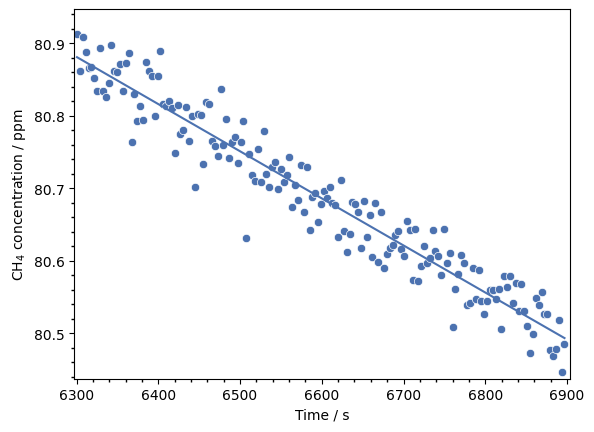

In [23]:
# Experiment1 10 minutes before light on
plt.figure()
sns.set_palette('deep')

ax = sns.scatterplot(x = full_df['Sec'][1810:1981], y = full_df['HR_12CH4'][1810:1981])
sns.lineplot(x = full_df['Sec'][1810:1981], y = full_df['fit_before_light'][1810:1981])

ax.set_xlabel('Time / s')
ax.set_ylabel('CH$_{4}$ concentration / ppm')
ax.set_xlim(full_df['Sec'][1809], full_df['Sec'][1982])
ax.set_ylim(full_df['HR_12CH4'][1990], full_df['HR_12CH4'][1800])

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis = 'both', which = 'major', direction = 'out', bottom = True, left = True)
ax.tick_params(axis = 'both', which = 'minor', direction = 'out', width = 1, length = 2, bottom = True, left = True)

plt.savefig('exp1_before_light.png')
plt.show()

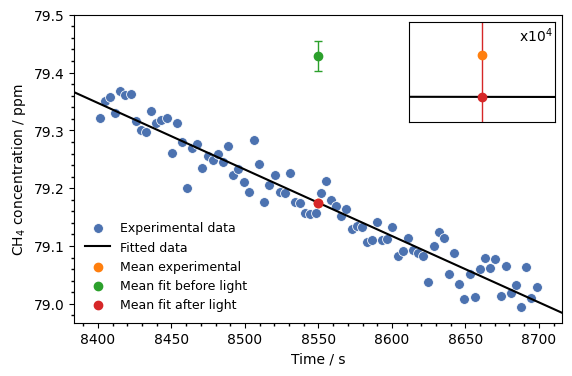

In [25]:
# Experiment1 5 minutes after light is turned off
fig, ax = plt.subplots(1,1, figsize = (6.3, 4))
sns.set_palette('deep')

ax = sns.scatterplot(x = full_df['Sec'][2410:2496], y = full_df['HR_12CH4'][2410:2496], label = 'Experimental data', s = 50, zorder = -10)
sns.lineplot(x = full_df['Sec'], y = full_df['fit_after_light'], zorder = -10, label = 'Fitted data', color = 'k')
plt.scatter(mean_exp1[0][0], mean_exp1[1][0], label = 'Mean experimental', color = 'tab:orange')
plt.scatter(mean_exp1[0][1], mean_exp1[1][1], label = 'Mean fit before light', color = 'tab:green')
plt.errorbar(mean_exp1[0][1], mean_exp1[1][1], yerr = yerror_before, color = 'tab:green', lw = 1, capsize = 3)
plt.scatter(mean_exp1[0][2], mean_exp1[1][2], label = 'Mean fit after light', color = 'tab:red')
plt.errorbar(mean_exp1[0][2], mean_exp1[1][2], yerr = yerror_after, color = 'tab:red', lw = 1, capsize = 3)

ax.set_xlabel('Time / s')
ax.set_ylabel('CH$_{4}$ concentration / ppm')
ax.set_xlim(full_df['Sec'][2405], full_df['Sec'][2500])
ax.set_ylim(full_df['HR_12CH4'][2500], 79.5)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis = 'both', which = 'major', direction = 'out', bottom = True, left = True)
ax.tick_params(axis = 'both', which = 'minor', direction = 'out', width = 1, length = 2, bottom = True, left = True)

ax.legend(frameon = False, loc = 3, fontsize = 9)

inset_ax = inset_axes(ax,
                    width="30%", # width = 30% of parent_bbox
                    height=1., # height : 1 inch
                    loc=1)
ax = sns.lineplot(x = full_df['Sec'], y = full_df['fit_after_light'], zorder = -10, color = 'k')
plt.scatter(mean_exp1[0][0], mean_exp1[1][0], color = 'tab:orange')
plt.scatter(mean_exp1[0][2], mean_exp1[1][2], color = 'tab:red')
plt.errorbar(mean_exp1[0][2], mean_exp1[1][2], yerr = yerror_after, color = 'tab:red', lw = 1, zorder = -10)
ax.text(full_df['Sec'][2410:2496].mean()+5*10**(-5), full_df['HR_12CH4'][2410:2496].mean()+2*10**(-5), 'x10$^{4}$')

ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_xlim(full_df['Sec'][2410:2496].mean()-10**(-4), full_df['Sec'][2410:2496].mean()+10**(-4))
ax.set_ylim(full_df['HR_12CH4'][2410:2496].mean()-10**(-4), full_df['HR_12CH4'][2410:2496].mean()+5*10**(-5))

plt.xticks([])
plt.yticks([])

plt.savefig('exp1_after_light.png', dpi = 150)
plt.show()

In [27]:
for i, time in enumerate(full_df['TIME']):
    if '16:13:00' in time:
        print(i, time, 'exp2')
    if '16:23:00' in time:
        print(i, time, 'exp2 light on')
    if '16:40:01' in time:
        print(i, time, 'exp2 light off')
    if '16:45:01' in time:
        print(i, time, 'exp2')
    if '16:50:01' in time:
        print(i, time, 'exp2')

5247 16:13:00.733 exp2
5421 16:23:00.447 exp2 light on
5717 16:40:01.096 exp2 light off
5804 16:45:01.270 exp2
5891 16:50:01.196 exp2


In [28]:
V_before_exp2, a_before_exp2, b_before_exp2, full_df['fit_before_light2'], meanx_before_exp2 = exp_fit(full_df['Sec'], 5247, 5421, full_df['HR_12CH4'])
V_after_exp2, a_after_exp2, b_after_exp2, full_df['fit_after_light2'], meanx_after_exp2 = exp_fit(full_df['Sec'], 5804, 5891, full_df['HR_12CH4'])

print('Before light is turned on')
print('a: ', a_before_exp2, '+/-', V_before_exp2[0][0])
print('b: ', b_before_exp2, '+/-', V_before_exp2[1][1])
print('After light is turned off')
print('a: ', a_after_exp2, '+/-', V_after_exp2[0][0])
print('b: ', b_after_exp2, '+/-', V_after_exp2[1][1])

a_sym = Symbol('a')
b_sym = Symbol('b')
z_before_exp2 = a_sym*exp(b_sym*meanx_after_exp2)
z_after_exp2 = a_sym*exp(b_sym*meanx_after_exp2)

y_before_exp2, yerror_before_exp2 = geterrors_corr(z_before_exp2, [a_sym, b_sym], [a_before_exp2, b_before_exp2], V_before_exp2)
y_after_exp2, yerror_after_exp2 = geterrors_corr(z_after_exp2, [a_sym, b_sym], [a_after_exp2, b_after_exp2], V_after_exp2)

mean_exp2 = np.array([[full_df['Sec'][5804:5891].mean(), meanx_after_exp2, meanx_after_exp2], 
                      [full_df['HR_12CH4'][5804:5891].mean(), y_before_exp2, y_after_exp2]])

print(y_before_exp2, yerror_before_exp2)
print(y_after_exp2, yerror_after_exp2)

Before light is turned on
a:  72.17248295819569 +/- 0.05187152372933581
b:  -8.044401327483203e-06 +/- 2.9164708389058376e-14
After light is turned off
a:  77.38495676825919 +/- 0.5553308768862143
b:  -1.138357597889841e-05 +/- 2.2617429625772042e-13
[[ 0.03744946 -0.04103552]
 [-0.04103552  0.04496891]]
[[ 0.35021897 -0.35021552]
 [-0.35021552  0.35021846]]
61.323925877336535 0.0186369988570345
61.454043697470205 0.002529452114932973


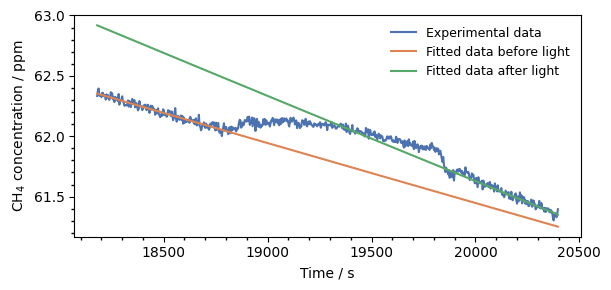

In [29]:
plt.figure(figsize = (6.3, 3))

ax = sns.lineplot(x = full_df['Sec'][5247:5891], y = full_df['HR_12CH4'][5247:5891], label = 'Experimental data')
sns.lineplot(x = full_df['Sec'][5247:5891], y = full_df['fit_before_light2'][5247:5891], label = 'Fitted data before light')
sns.lineplot(x = full_df['Sec'][5247:5891], y = full_df['fit_after_light2'][5247:5891], label = 'Fitted data after light')

ax.set_xlabel('Time / s')
ax.set_ylabel('CH$_{4}$ concentration / ppm')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis = 'both', which = 'major', direction = 'out', bottom = True, left = True)
ax.tick_params(axis = 'both', which = 'minor', direction = 'out', width = 1, length = 2, bottom = True, left = True)

ax.legend(frameon = False, fontsize = 9)

plt.tight_layout()
plt.savefig('exp2_full.png', dpi = 150)
plt.show()

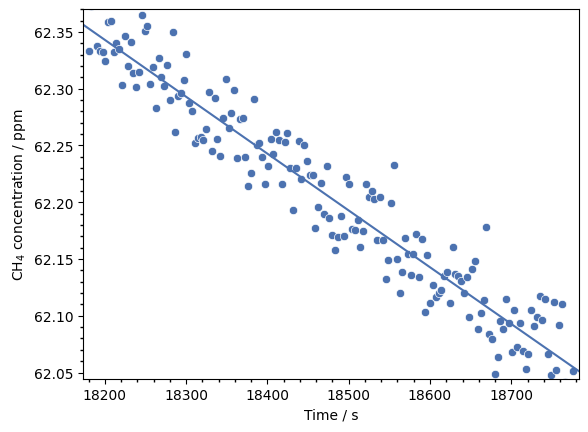

In [31]:
plt.figure()
sns.set_palette('deep')

ax = sns.scatterplot(x = full_df['Sec'][5247:5421], y = full_df['HR_12CH4'][5247:5421])
sns.lineplot(x = full_df['Sec'], y = full_df['fit_before_light2'])

ax.set_xlabel('Time / s')
ax.set_ylabel('CH$_{4}$ concentration / ppm')
ax.set_xlim(full_df['Sec'][5245], full_df['Sec'][5422])
ax.set_ylim(full_df['HR_12CH4'][5422], full_df['HR_12CH4'][5245])

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis = 'both', which = 'major', direction = 'out', bottom = True, left = True)
ax.tick_params(axis = 'both', which = 'minor', direction = 'out', width = 1, length = 2, bottom = True, left = True)

plt.savefig('exp2_before_light.png', dpi = 150)
plt.show()

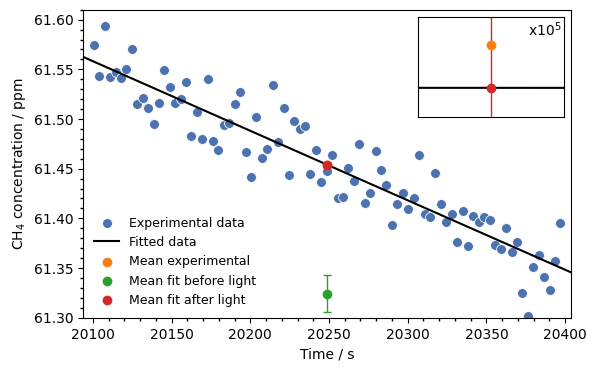

In [39]:
fig, ax = plt.subplots(1,1, figsize = (6.3, 4))
sns.set_palette('deep')

sns.scatterplot(x = full_df['Sec'][5804:5891], y = full_df['HR_12CH4'][5804:5891], label = 'Experimental data', s = 50, zorder = -10)
sns.lineplot(x = full_df['Sec'], y = full_df['fit_after_light2'], zorder = -10, label = 'Fitted data', color = 'k')
plt.scatter(mean_exp2[0][0], mean_exp2[1][0], label = 'Mean experimental', color = 'tab:orange')
plt.scatter(mean_exp2[0][1], mean_exp2[1][1], label = 'Mean fit before light', color = 'tab:green')
plt.errorbar(mean_exp2[0][1], mean_exp2[1][1], yerr = yerror_before_exp2, color = 'tab:green', lw = 1, capsize = 3)
plt.scatter(mean_exp2[0][2], mean_exp2[1][2], label = 'Mean fit after light', color = 'tab:red')
plt.errorbar(mean_exp2[0][2], mean_exp2[1][2], yerr = yerror_after_exp2, color = 'tab:red', lw = 1, capsize = 3, zorder = -5)

ax.set_xlabel('Time / s')
ax.set_ylabel('CH$_{4}$ concentration / ppm')
ax.set_xlim(full_df['Sec'][5802], full_df['Sec'][5892])
ax.set_ylim(61.3, 61.61)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis = 'both', which = 'major', direction = 'out', bottom = True, left = True)
ax.tick_params(axis = 'both', which = 'minor', direction = 'out', width = 1, length = 2, bottom = True, left = True)

ax.legend(frameon = False, loc = 3, fontsize = 9)

inset_ax = inset_axes(ax,
                    width="30%", # width = 30% of parent_bbox
                    height=1., # height : 1 inch
                    loc=1)
ax = sns.lineplot(x = full_df['Sec'], y = full_df['fit_after_light2'], zorder = -10, color = 'k')
plt.scatter(mean_exp2[0][0], mean_exp2[1][0], color = 'tab:orange')
plt.scatter(mean_exp2[0][2], mean_exp2[1][2], color = 'tab:red')
plt.errorbar(mean_exp2[0][2], mean_exp2[1][2], yerr = yerror_after_exp2, ecolor = 'tab:red', lw = 1, zorder = -10)
ax.text(full_df['Sec'][5804:5891].mean()+5*10**(-6), full_df['HR_12CH4'][5804:5891].mean()+7*10**(-6), 'x10$^{5}$')

ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_xlim(full_df['Sec'][5804:5891].mean()-10**(-5), full_df['Sec'][5804:5891].mean()+10**(-5))
ax.set_ylim(full_df['HR_12CH4'][5804:5891].mean()-5*10**(-5), full_df['HR_12CH4'][5804:5891].mean()+2*10**(-5))

plt.xticks([])
plt.yticks([])

plt.savefig('exp2_after_light.png', dpi = 150)
plt.show()

In [53]:
def make_subplots(axes, data, min_index, max_index, fit_before, fit_after, index_on, index_off, interval, on, off):
    ax = axes
    sns.lineplot(x = data['Sec'][min_index:max_index], y = data['HR_12CH4'][min_index:max_index], ax=ax, color = 'tab:blue', label = 'Experimental data')
    sns.lineplot(x = data['Sec'][min_index:max_index], y = data[fit_before][min_index:max_index], ax=ax, color = 'tab:orange', label = 'Fitted data before light')
    sns.lineplot(x = data['Sec'][min_index:max_index], y = data[fit_after][min_index:max_index], ax=ax, color = 'tab:green', label = 'Fitted data after light')
    ax.vlines(data['Sec'][index_on], data[fit_before][index_on]-interval, data[fit_before][index_on]+interval, color = 'tab:red', zorder = 10)
    ax.vlines(data['Sec'][index_off], data['HR_12CH4'][index_off]-interval, data['HR_12CH4'][index_off]+interval, color = 'tab:red', zorder = 10)
    ax.text(data['Sec'][index_on]+150, data[fit_before][index_on]-on, 'Light on', ha = 'right')
    ax.text(data['Sec'][index_off]-150, data['HR_12CH4'][index_off]+off, 'Light off', ha = 'left')
    ax.set_ylabel(None, fontsize = 0)
    ax.set_xlabel(None, fontsize = 0)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis = 'both', which = 'major', direction = 'out', bottom = True, left = True, labelsize = 8)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'out', width = 1, length = 2, bottom = True, left = True)
    ax.legend(frameon = False, fontsize = 10)
    ax.yaxis.offsetText.set_fontsize(8)

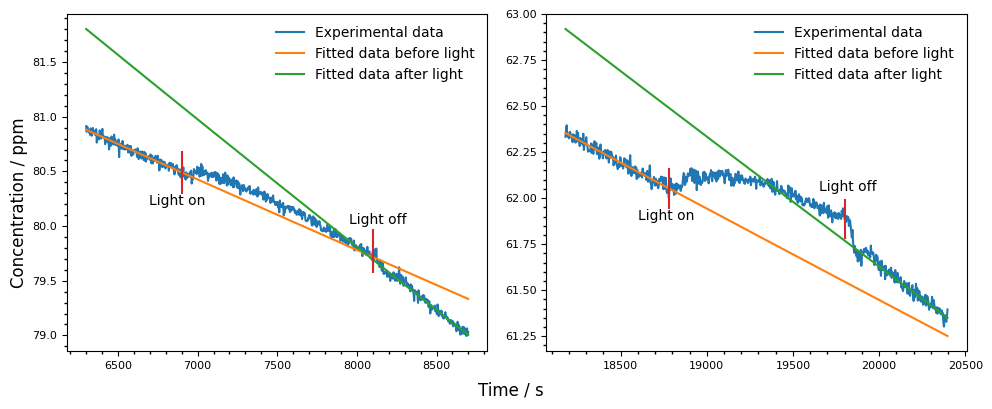

In [55]:
fig, axes = plt.subplots(1,2, figsize = (10,4))

make_subplots(axes[0], full_df, 1810, 2496, 'fit_before_light', 'fit_after_light', 1981, 2324, 0.2, 0.3, 0.25)
axes[0].set_ylabel(' ', fontsize = 4)

make_subplots(axes[1], full_df, 5247, 5891, 'fit_before_light2', 'fit_after_light2', 5421, 5717, 0.11, 0.17, 0.15)
axes[1].set_ylabel(' ', fontsize = 4)


fig.supxlabel('        Time / s')
fig.supylabel('Concentration / ppm')

plt.tight_layout(pad = 0.5)
plt.savefig('full_experiment.png', dpi = 150)
plt.show()

In [42]:
def make_subplots_before(axes, data, min_index, max_index, fit):
    ax = axes
    sns.scatterplot(x = data['Sec'][min_index:max_index], y = data['HR_12CH4'][min_index:max_index], ax=ax, color = 'tab:blue', label = 'Experimental data')
    sns.lineplot(x = data['Sec'][min_index-10:max_index+10], y = data[fit][min_index-10:max_index+10], ax=ax, color = 'tab:blue', label = 'Fitted data')
    ax.set_ylabel(None, fontsize = 0)
    ax.set_xlabel(None, fontsize = 0)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis = 'both', which = 'major', direction = 'out', bottom = True, left = True, labelsize = 8)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'out', width = 1, length = 2, bottom = True, left = True)
    ax.legend(frameon = False, fontsize = 8)
    ax.yaxis.offsetText.set_fontsize(8)

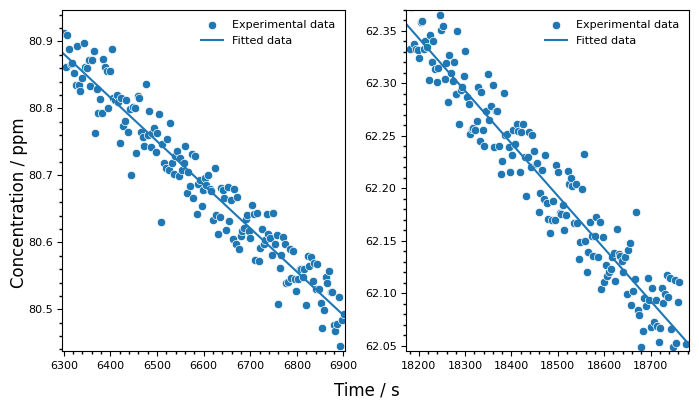

In [43]:
fig, axes = plt.subplots(1,2, figsize = (7,4))

make_subplots_before(axes[0], full_df, 1810, 1982, 'fit_before_light')
axes[0].set_xlim(full_df['Sec'][1809], full_df['Sec'][1982])
axes[0].set_ylim(full_df['HR_12CH4'][1990], full_df['HR_12CH4'][1800])

make_subplots_before(axes[1], full_df, 5247, 5421, 'fit_before_light2')
axes[1].set_xlim(full_df['Sec'][5245], full_df['Sec'][5422])
axes[1].set_ylim(full_df['HR_12CH4'][5422], full_df['HR_12CH4'][5245])

fig.supxlabel('        Time / s')
fig.supylabel('Concentration / ppm')

plt.tight_layout(pad = 0.5)
plt.savefig('exp_before.png', dpi = 150)
plt.show()